In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2017-07-12,WMB,2017-07-12,30.8200,31.0300,30.6800,30.7900,21.8626,4098041,2.521354e+10
2011-11-16,ASH,2011-11-16,54.4632,57.2234,54.3632,55.1933,23.1465,2667620,4.314443e+09
2016-04-27,HAL,2016-04-27,40.2300,41.5800,40.2300,41.0400,36.2288,11826400,3.450876e+10
2020-06-17,MYL,2020-06-17,16.5300,16.6000,15.8900,15.9700,15.9700,5064133,8.339210e+09
2021-10-21,VNO,2021-10-21,45.9500,46.1200,44.3300,44.7500,40.5115,890937,8.797216e+09


In [9]:
def better_sinewave(close, length=None, bars=None, offset=None, **kwargs):
    """Indicator: Even Better SineWave (EBSW)"""
    # Validate arguments
    length = int(length) if length and length > 38 else 40
    bars = int(bars) if bars and bars > 0 else 10
    offset = int(offset) if offset else 0

    if close is None: return

    # variables
    alpha1 = HP = 0 # alpha and HighPass
    a1 = b1 = c1 = c2 = c3 = 0
    Filt = Pwr = Wave = 0

    lastClose = lastHP = 0
    FilterHist = [0, 0]   # Filter history

    # Calculate Result
    m = close.size
    result = [np.nan for _ in range(0, length - 1)] + [0]
    for i in range(length, m):
        # HighPass filter cyclic components whose periods are shorter than Duration input
        alpha1 = (1 - np.sin(360 / length)) / np.cos(360 / length)
        HP = 0.5 * (1 + alpha1) * (close[i] - lastClose) + alpha1 * lastHP

        # Smooth with a Super Smoother Filter from equation 3-3
        a1 = np.exp(-np.sqrt(2) * np.pi / bars)
        b1 = 2 * a1 * np.cos(np.sqrt(2) * 180 / bars)
        c2 = b1
        c3 = -1 * a1 * a1
        c1 = 1 - c2 - c3
        Filt = c1 * (HP + lastHP) / 2 + c2 * FilterHist[1] + c3 * FilterHist[0]
        # Filt = float("{:.8f}".format(float(Filt))) # to fix for small scientific notations, the big ones fail

        # 3 Bar average of Wave amplitude and power
        Wave = (Filt + FilterHist[1] + FilterHist[0]) / 3
        Pwr = (Filt * Filt + FilterHist[1] * FilterHist[1] + FilterHist[0] * FilterHist[0]) / 3

        # Normalize the Average Wave to Square Root of the Average Power
        Wave = Wave / np.sqrt(Pwr)

        # update storage, result
        FilterHist.append(Filt)  # append new Filt value
        FilterHist.pop(0)  # remove first element of list (left) -> updating/trim
        lastHP = HP
        lastClose = close[i]
        result.append(Wave)

    ebsw = pd.Series(result, index=close.index)

    # Offset
    if offset != 0:
        ebsw = ebsw.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        ebsw.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        ebsw.fillna(method=kwargs["fill_method"], inplace=True)

    return ebsw

In [12]:
import pandas_ta as ta
from tqdm import tqdm
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = better_sinewave(df_ticker['close'],bars = 5,length=40)
        results[ticker] = metrics

    except :
        print(ticker, 'not computed')

results = pd.concat(results,axis=1)
results = results.reindex_like(P).ffill()


 12%|█▏        | 107/866 [00:05<00:36, 20.81it/s]

BHGE not computed


 44%|████▍     | 379/866 [00:20<00:29, 16.37it/s]

HET not computed


100%|██████████| 866/866 [00:49<00:00, 17.67it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_24088\3699890209.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe      1.4
Turnover    0.8
biais       2.7
dtype: float64

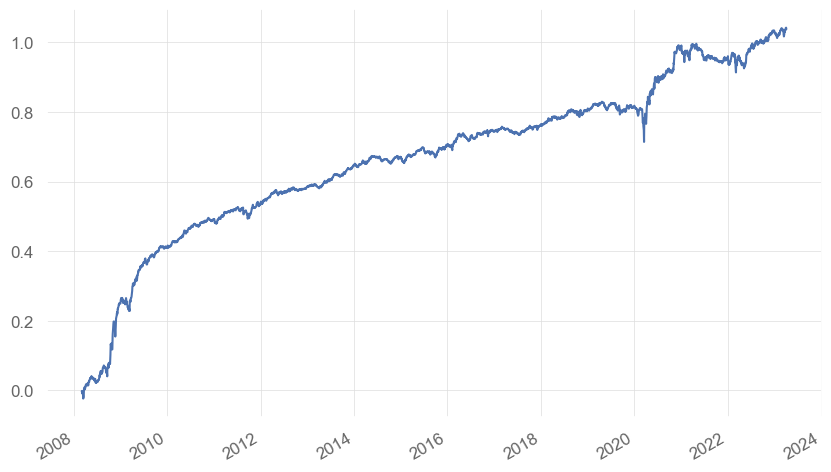

In [13]:
signal = results[P].ffill()
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)

<Axes: >

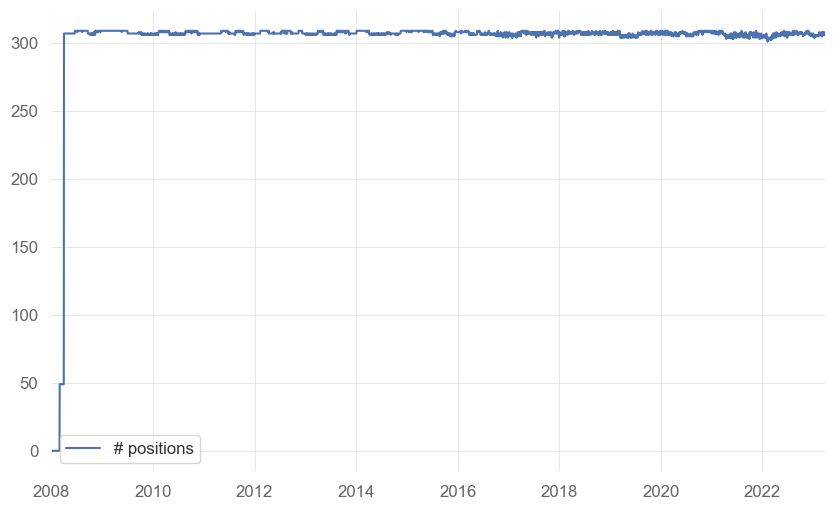

In [14]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

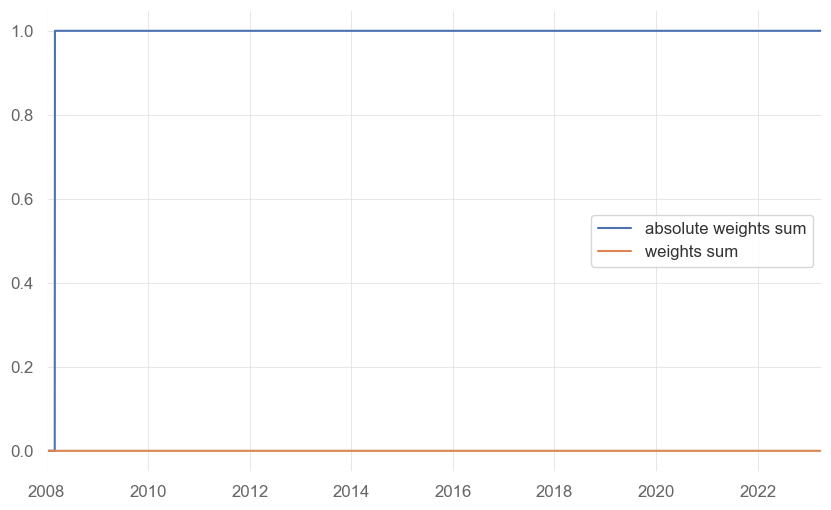

In [15]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)